In [1]:
import sys
print sys.prefix
print sys.version

/opt/mapr/EDSIADM/anaconda2/envs/pyaphp
2.7.12 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:42:40) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


# 3 tables created in our Drill/parquet database to speed up queries

In [2]:
"""
Table : icu_nda_mouv_ufr_tr
==> mouvements related with ICU entities
"""
# create table icu_nda_mouv_ufr_tr as
# select n.* from nda_mouv_ufr_tr n, icu_ufr u
# where u.ids_ufr=n.ids_ufr

"""
Table : icu_sensor_24
==> measures done in ICU entities and in the first 24h after entrances
"""
# create table icu_sensor_24 as
# select TO_DATE(n.dt_deb_mouv_ufr) as dt_deb, s.* 
#       from icu_sensors s, icu_nda_mouv_ufr_tr n
#       where cast(s.id_nda as VARCHAR)=n.id_nda and
#       s.dt_insert >= n.dt_deb_mouv_ufr and
#       s.dt_insert <= n.dt_deb_mouv_ufr + interval '1' DAY(2)

# # Création d'une table id_nda, min_dt_deb_mouv, max_dt_deb_mouv, max_dt_fin_mouv
# # pour les visites en soins intensifs

"""
Table : icu_pat_info
==> information about patients involved in previous mouvements and measures
"""
# create table icu_pat_info as
# select n.id_nda, p.age,
#     min(n.dt_deb_mouv_ufr) as min_dt_deb_mouv,
#     max(n.dt_deb_mouv_ufr) as max_dt_deb_mouv,
#     max(n.dt_fin_mouv_ufr) as max_dt_fin_mouv,
#     p.cd_sex_tr, p.dt_deces
#     from nda_mouv_ufr_tr n, patient_tr p
#     where p.ids_pat = n.ids_pat and
#     n.id_nda in (select distinct cast(id_nda as VARCHAR) from icu_sensor_24)
#     group by n.id_nda, p.age, p.cd_sex_tr, p.dt_deces

In [3]:
import pyodbc
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
%matplotlib inline

# function to store a query result in a pandas DataFrame

In [4]:
def df_from_query(conn, query):
    """
    Query an ODBC datasource and set results in a pandas Dataframe
    
    Parameters
    ----------
    pyodbc.Connection conn : Datasource ODBC connection
    string           query : query to execute on datasource
    """
    c = conn.cursor()
    c.execute(query)
    cols = [column[0] for column in c.description]
    data = []
    for row in c.fetchall():
        data.append(tuple(row))
    df = pd.DataFrame(data, columns=cols)
    return df

# Connection to Drill database

In [5]:
#
# Drillbit ODBC connection
#
# conn = pyodbc.connect("DSN=MapR ODBC Driver for Drill DSN", autocommit=True)
conn = pyodbc.connect("DSN=drill_eds", autocommit=True)

# Number of measures by type

In [6]:
#
# Most frequent types of measures between H0 and H24 in ICUs
#
q1 = "select count(1) as counter,s.id_measure_type, r.label \
      from icu_sensor_24 s, ref_measure r \
      where s.id_measure_type = cast(r.code as INT) \
      and s.dt_cancel = '' \
      group by s.id_measure_type, r.label \
      order by counter desc, s.id_measure_type, r.label"

df = df_from_query(conn, q1)
df['label'] = df['label'].str.decode('iso-8859-1').str.encode('utf8')
df.head(20)

,counter,id_measure_type,label
0,246490,10102,Fréquence cardiaque
1,243159,10168,Saturation pulsée Oxygène
2,237342,10120,Frequence respiratoire
3,191174,10121,Mode Ventilatoire
4,146710,11,Pression artérielle non invasive systolique
5,145689,12,Pression artérielle non invasive diastolique
6,142949,13,Pression artérielle non invasive moyenne
7,140900,10281,MEGS PAS Intervalle 2h
8,140433,10282,MEGS PAM intervalle 2h
9,140124,10283,MEGS PAD intervalle 2h


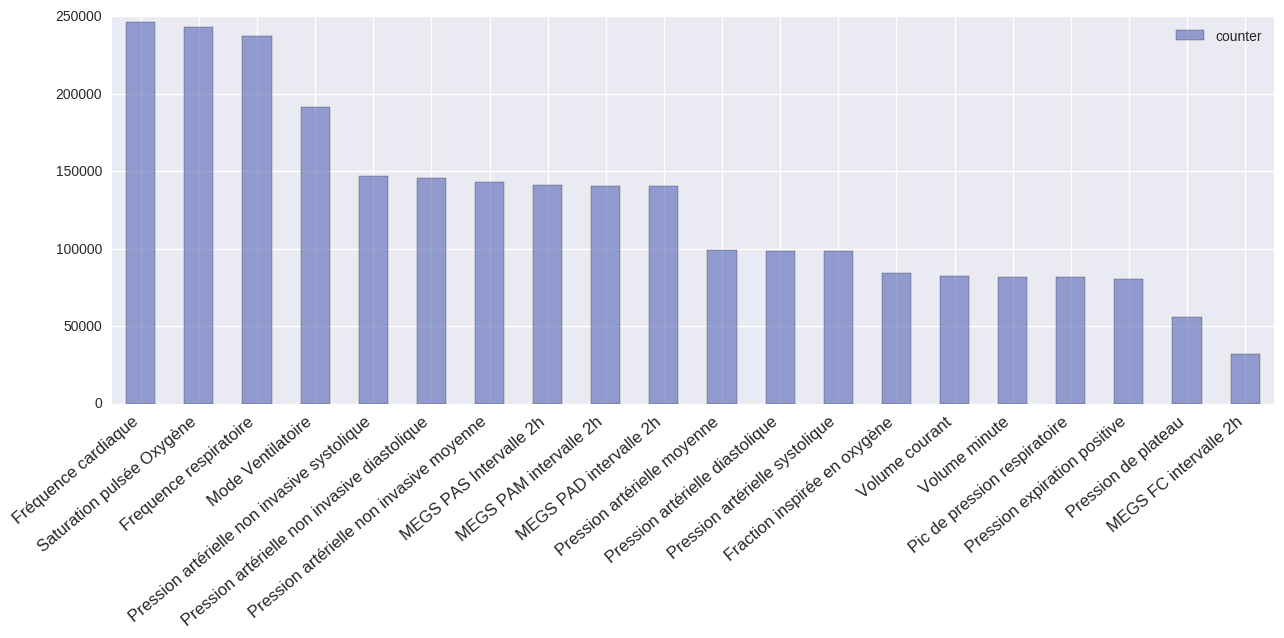

In [7]:
ax = df[['counter', 'label']].head(20).plot(kind = 'bar', color = '#5566b7', alpha=0.6, figsize=(15, 5))
ax.set_xticklabels(df['label'].str.decode('utf8'), rotation=40, fontsize=12, ha='right')

# Number of UCUs stays having measures in the first 24h after entrances

In [8]:
#
# How many ICUs stays (with H0-24 measures) ?
#
q2 = "select count(distinct s.id_nda) \
    from icu_sensor_24 s \
    where s.id_measure_type in (10102, 10120, 11, 12, 14, 15) \
    and s.dt_cancel = ''"

df_from_query(conn, q2)

,EXPR$0
0,3557


# Select H0-24 measures of interest by stay:
<ul>
<li>10102 : Heart rate</li>
<li>10120 : Respiration rate</li>
<li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;11 : ABP systolic (invasive)</li>
<li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;12 : ABP diastolic (invasive)</li>
<li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;14 : ABP systolic (not invasive)</li>
<li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;15 : ABP diastolic (not invasive)</li>
</ul>

note: we have composed a new key to identify a unique ICU admission <br>
This key is id_nda(APHP stay) + dt_deb (entrance in ICU)<br>
Indeed a patient can have several ICUs entrances during an APHP stay

In [9]:
#
# Number of measures by stay and measure type (only 10102, 10120, 11, 12, 14, 15)
#
q3 = "select CONCAT(cast(id_nda as VARCHAR),cast(TO_DATE(dt_deb) as VARCHAR)) as id_ndaj1, \
      s.id_measure_type, count(1) as counter \
      from icu_sensor_24 s \
      where s.id_measure_type in (10102, 10120, 11, 12, 14, 15) \
      and s.dt_cancel = '' \
      group by CONCAT(cast(id_nda as VARCHAR),cast(TO_DATE(dt_deb) as VARCHAR)), s.id_measure_type \
      order by CONCAT(cast(id_nda as VARCHAR),cast(TO_DATE(dt_deb) as VARCHAR)), s.id_measure_type"

df_feat = df_from_query(conn, q3)
df_feat.head()

,id_ndaj1,id_measure_type,counter
0,27445892014-05-08,11,67
1,27445892014-05-08,12,66
2,27445892014-05-08,14,41
3,27445892014-05-08,15,41
4,27445892014-05-08,10102,97


In [10]:
df_feat.shape

(16394, 3)

In [11]:
#
# Do a pivot to get a matrix
#
df_pivot = df_feat.pivot(index='id_ndaj1',columns='id_measure_type',values='counter')
df_pivot.head(10)

id_measure_type,11,12,14,15,10102,10120
id_ndaj1,,,,,,
27445892014-05-08,67.0,66.0,41.0,41.0,97.0,96.0
27445892014-06-24,25.0,25.0,96.0,96.0,96.0,96.0
27542662014-05-05,NaN,NaN,83.0,83.0,83.0,83.0
27556882014-04-30,NaN,NaN,NaN,NaN,2.0,2.0
27584082014-05-12,NaN,NaN,93.0,93.0,93.0,92.0
27606232014-05-01,NaN,NaN,60.0,60.0,60.0,60.0
27613822014-05-01,5.0,NaN,14.0,14.0,17.0,17.0
27632822014-05-02,43.0,NaN,NaN,NaN,84.0,84.0
27642382014-05-06,NaN,NaN,48.0,48.0,47.0,46.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7921fdbe90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f7921db9410>]], dtype=object)

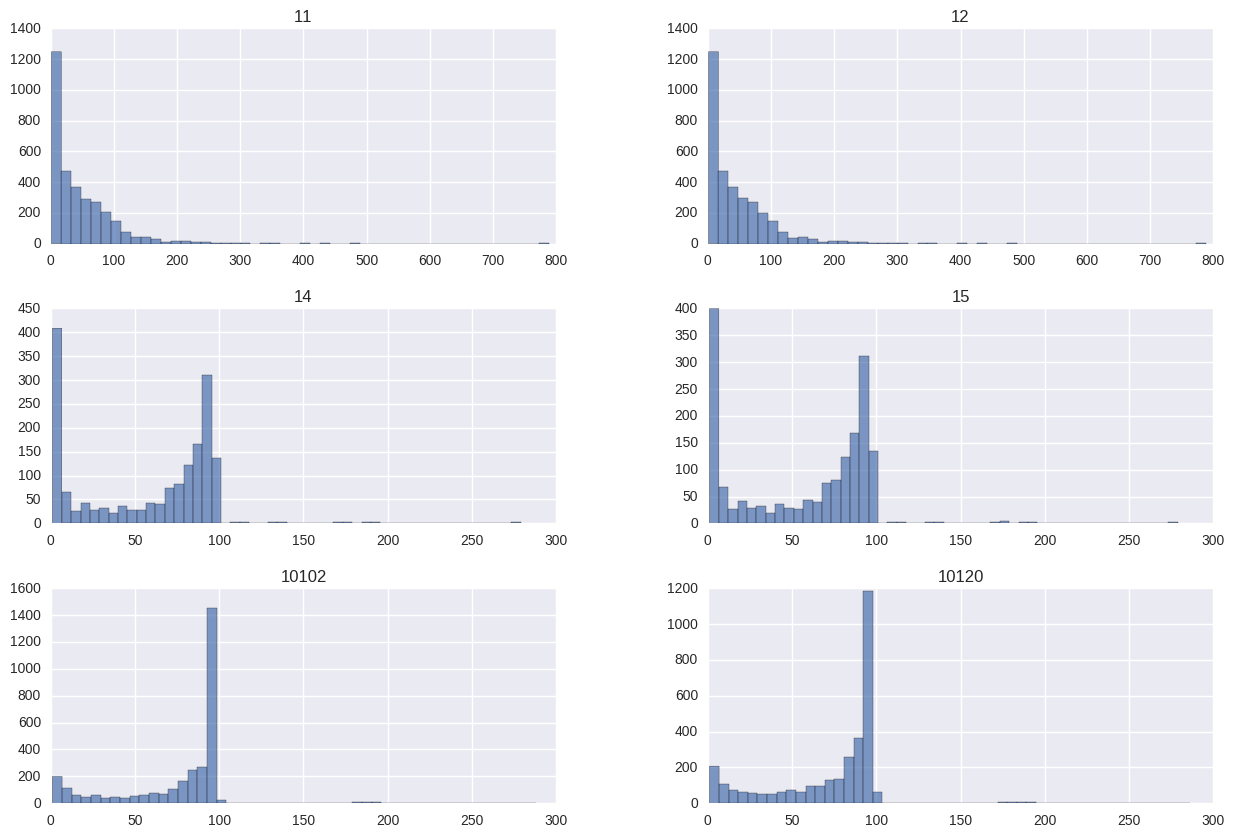

In [12]:
df_pivot.hist(figsize=(15, 10), bins=50, alpha=0.7)

# Remove rows when no HR measure or no RR measure

In [13]:
df_pivot1 = df_pivot[df_pivot[10102].notnull() & df_pivot[10120].notnull()]
df_pivot1.shape

(3202, 6)

# Remove rows when incomplete ABPs

In [14]:
df_pivot1 = df_pivot1[(df_pivot1[11].notnull() & df_pivot1[12].notnull()) | (df_pivot1[14].notnull() & df_pivot1[15].notnull())]
df_pivot1.shape

(3198, 6)

# Keep rows only when measures are more than 10 for HR, RR and ABPs

In [15]:
# !!! Tracer la courbe des effectifs en fonction du nombre de points

nb_min_pts = 10
df_pivot2 = df_pivot1[((df_pivot1[11]>=nb_min_pts) & (df_pivot1[12]>=nb_min_pts)) | \
                      ((df_pivot1[14]>=nb_min_pts) & (df_pivot1[15]>=nb_min_pts))]
print(df_pivot2.shape)
df_pivot2 = df_pivot2[(df_pivot2[10102]>=nb_min_pts) & (df_pivot2[10120]>=nb_min_pts)]
print(df_pivot2.shape)

(2892, 6)
(2838, 6)


# Filter ==> keep only patients more than 18 years old

In [16]:
q4 = "select distinct CONCAT(cast(s.id_nda as VARCHAR),cast(TO_DATE(s.dt_deb) as VARCHAR)) as id_ndaj1, \
p.age, p.dt_deces from icu_pat_info p, icu_sensor_24 s \
where p.id_nda = cast(s.id_nda as VARCHAR) \
and s.dt_cancel = ''"
df_pat = df_from_query(conn, q4)

In [17]:
df_pivot2['id_ndaj1'] = df_pivot2.index
df_pivot2.head()

id_measure_type,11,12,14,15,10102,10120,id_ndaj1
id_ndaj1,,,,,,,
27445892014-05-08,67.0,66.0,41.0,41.0,97.0,96.0,27445892014-05-08
27445892014-06-24,25.0,25.0,96.0,96.0,96.0,96.0,27445892014-06-24
27542662014-05-05,NaN,NaN,83.0,83.0,83.0,83.0,27542662014-05-05
27584082014-05-12,NaN,NaN,93.0,93.0,93.0,92.0,27584082014-05-12
27606232014-05-01,NaN,NaN,60.0,60.0,60.0,60.0,27606232014-05-01


In [18]:
print(df_pat.shape)
df_pat.head()

(4253, 3)


,id_ndaj1,age,dt_deces
0,28227132014-06-06,65.916496,2015-05-11 14:55:00
1,29802812014-06-07,74.472279,NaT
2,28227132014-06-08,65.916496,2015-05-11 14:55:00
3,34376152014-09-07,70.228611,2014-09-24 10:55:00
4,34461412014-09-08,58.833676,NaT


 ## Join the 2 dataframes

In [19]:
result = pd.merge(df_pivot2,df_pat, how='inner', on=['id_ndaj1'])
result.shape

(2838, 9)

In [20]:
result2 = result[result['age']>=18]
result2.shape

(2825, 9)

In [21]:
result2[result2['dt_deces'].notnull()].shape

(638, 9)

## Mortality rate :

In [22]:
# mortality rate
float(result2[result2['dt_deces'].notnull()].shape[0]) / float(result2.shape[0]) * 100.

22.584070796460175

In [23]:
result[(result['age']<18)&(result['dt_deces'].notnull())].shape

(0, 9)

In [24]:
result['id_ndaj1'].unique().shape

(2838,)

# ===============================================================     We have kept all ICUs stays with more than 10 measures for each variable of interest and related with patients more than 18 : 2838 cases kept                            ==============================================================

# Lets have a look on ICUs stays durations

# Lookup for cases where window is less than 6h

In [25]:
#
# Recherche des cas pour lesquels l'intervalle des mesures disponibles est > 6h
#
q6 = "select CONCAT(cast(id_nda as VARCHAR),cast(TO_DATE(dt_deb) as VARCHAR)) as id_ndaj1, \
id_measure_type, min(dt_insert) as min_dt \
from icu_sensor_24 \
where id_measure_type in(11,12,14,15,10102,10120) \
and dt_cancel = '' \
group by CONCAT(cast(id_nda as VARCHAR),cast(TO_DATE(dt_deb) as VARCHAR)), id_measure_type \
order by CONCAT(cast(id_nda as VARCHAR),cast(TO_DATE(dt_deb) as VARCHAR)), id_measure_type"

# selection et pivot
df_dt_min = df_from_query(conn, q6)
df_dt_min = df_dt_min.pivot(index='id_ndaj1',columns='id_measure_type',values='min_dt')
df_dt_min.head()

id_measure_type,11,12,14,15,10102,10120
id_ndaj1,,,,,,
27445892014-05-08,2014-05-08 01:17:53,2014-05-08 01:17:53,2014-05-08 00:44:00,2014-05-08 00:44:00,2014-05-08 00:44:00,2014-05-08 00:43:00
27445892014-06-24,2014-06-24 20:54:32,2014-06-24 20:54:32,2014-06-24 19:13:09,2014-06-24 19:13:09,2014-06-24 19:06:41,2014-06-24 19:01:31
27542662014-05-05,NaT,NaT,2014-05-05 16:44:01,2014-05-05 16:44:01,2014-05-05 16:44:01,2014-05-05 16:44:01
27556882014-04-30,NaT,NaT,NaT,NaT,2014-04-30 18:33:40,2014-04-30 18:33:40
27584082014-05-12,NaT,NaT,2014-05-12 18:00:00,2014-05-12 17:59:00,2014-05-12 17:59:00,2014-05-12 18:54:21


In [26]:
#
# Recherche des cas pour lesquels l'intervalle des mesures disponibles est > 6h
#
q7 = "select CONCAT(cast(id_nda as VARCHAR),cast(TO_DATE(dt_deb) as VARCHAR)) as id_ndaj1, \
id_measure_type, max(dt_insert) as max_dt \
from icu_sensor_24 \
where id_measure_type in(11,12,14,15,10102,10120) \
and dt_cancel = '' \
group by CONCAT(cast(id_nda as VARCHAR),cast(TO_DATE(dt_deb) as VARCHAR)), id_measure_type \
order by CONCAT(cast(id_nda as VARCHAR),cast(TO_DATE(dt_deb) as VARCHAR)), id_measure_type"

# selection et pivot
df_dt_max = df_from_query(conn, q7)
df_dt_max = df_dt_max.pivot(index='id_ndaj1',columns='id_measure_type',values='max_dt')
df_dt_max.head()

id_measure_type,11,12,14,15,10102,10120
id_ndaj1,,,,,,
27445892014-05-08,2014-05-08 15:32:35,2014-05-08 15:32:35,2014-05-09 00:21:01,2014-05-09 00:21:01,2014-05-09 00:21:01,2014-05-09 00:21:41
27445892014-06-24,2014-06-25 00:47:43,2014-06-25 00:47:43,2014-06-25 18:46:10,2014-06-25 18:46:10,2014-06-25 18:46:10,2014-06-25 18:46:02
27542662014-05-05,NaT,NaT,2014-05-06 16:28:09,2014-05-06 16:28:09,2014-05-06 16:28:09,2014-05-06 16:28:09
27556882014-04-30,NaT,NaT,NaT,NaT,2014-04-30 18:34:11,2014-04-30 18:34:11
27584082014-05-12,NaT,NaT,2014-05-13 17:38:01,2014-05-13 17:38:01,2014-05-13 17:38:01,2014-05-13 17:40:11


In [27]:
df_diff_dt = df_dt_max - df_dt_min
df_diff_dt.head(20)

id_measure_type,11,12,14,15,10102,10120
id_ndaj1,,,,,,
27445892014-05-08,14:14:42,14:14:42,23:37:01,23:37:01,23:37:01,23:38:41
27445892014-06-24,03:53:11,03:53:11,23:33:01,23:33:01,23:39:29,23:44:31
27542662014-05-05,NaT,NaT,23:44:08,23:44:08,23:44:08,23:44:08
27556882014-04-30,NaT,NaT,NaT,NaT,00:00:31,00:00:31
27584082014-05-12,NaT,NaT,23:38:01,23:39:01,23:39:01,22:45:50
27606232014-05-01,NaT,NaT,14:44:09,14:44:09,14:44:09,14:43:10
27613822014-05-01,02:31:02,NaT,03:44:00,03:44:00,03:58:49,03:58:49
27632822014-05-02,20:32:02,NaT,NaT,NaT,20:44:10,20:43:40
27642382014-05-06,NaT,NaT,23:23:08,23:23:08,23:23:08,23:14:01


In [28]:
delta_min = timedelta(hours=6)
result3 = df_diff_dt[(
                ((df_diff_dt[11]>=delta_min)|(df_diff_dt[14]>=delta_min)) &
                ((df_diff_dt[12]>=delta_min)|(df_diff_dt[15]>=delta_min)) &
                (df_diff_dt[10102]>=delta_min) &
                (df_diff_dt[10120]>=delta_min)
            )]
result3.shape

(2932, 6)

In [29]:
result3.head(20)

id_measure_type,11,12,14,15,10102,10120
id_ndaj1,,,,,,
27445892014-05-08,14:14:42,14:14:42,23:37:01,23:37:01,23:37:01,23:38:41
27445892014-06-24,03:53:11,03:53:11,23:33:01,23:33:01,23:39:29,23:44:31
27542662014-05-05,NaT,NaT,23:44:08,23:44:08,23:44:08,23:44:08
27584082014-05-12,NaT,NaT,23:38:01,23:39:01,23:39:01,22:45:50
27606232014-05-01,NaT,NaT,14:44:09,14:44:09,14:44:09,14:43:10
27642382014-05-06,NaT,NaT,23:23:08,23:23:08,23:23:08,23:14:01
27668302014-05-23,20:30:11,20:30:11,NaT,NaT,20:29:50,20:29:40
27717732014-05-11,NaT,NaT,16:44:00,16:44:00,16:44:00,16:43:30
27736182014-05-06,01:19:53,01:19:53,22:04:10,22:04:10,23:40:19,23:40:20


In [30]:
result3 = result3.reset_index()
result3.head(20)

id_measure_type,id_ndaj1,11,12,14,15,10102,10120
0,27445892014-05-08,14:14:42,14:14:42,23:37:01,23:37:01,23:37:01,23:38:41
1,27445892014-06-24,03:53:11,03:53:11,23:33:01,23:33:01,23:39:29,23:44:31
2,27542662014-05-05,NaT,NaT,23:44:08,23:44:08,23:44:08,23:44:08
3,27584082014-05-12,NaT,NaT,23:38:01,23:39:01,23:39:01,22:45:50
4,27606232014-05-01,NaT,NaT,14:44:09,14:44:09,14:44:09,14:43:10
5,27642382014-05-06,NaT,NaT,23:23:08,23:23:08,23:23:08,23:14:01
6,27668302014-05-23,20:30:11,20:30:11,NaT,NaT,20:29:50,20:29:40
7,27717732014-05-11,NaT,NaT,16:44:00,16:44:00,16:44:00,16:43:30
8,27736182014-05-06,01:19:53,01:19:53,22:04:10,22:04:10,23:40:19,23:40:20
9,27789292014-07-14,22:59:48,22:59:48,NaT,NaT,22:59:40,22:59:40


In [31]:
result = pd.merge(result2,result3, how='inner', on=['id_ndaj1'])
result.shape

(2701, 15)

# ===============================================================     We have kept all ICUs stays with more than 10 measures for each variable of interest and related with patients more than 18 and for whose we have more than 6h of measures : 2701 cases kept                            ==============================================================

In [32]:
result.head(20)

id_measure_type,11_x,12_x,14_x,15_x,10102_x,10120_x,id_ndaj1,age,dt_deces,11_y,12_y,14_y,15_y,10102_y,10120_y
0,67.0,66.0,41.0,41.0,97.0,96.0,27445892014-05-08,62.171116,2014-08-04 05:33:00,14:14:42,14:14:42,23:37:01,23:37:01,23:37:01,23:38:41
1,25.0,25.0,96.0,96.0,96.0,96.0,27445892014-06-24,62.171116,2014-08-04 05:33:00,03:53:11,03:53:11,23:33:01,23:33:01,23:39:29,23:44:31
2,NaN,NaN,83.0,83.0,83.0,83.0,27542662014-05-05,55.961670,NaT,NaT,NaT,23:44:08,23:44:08,23:44:08,23:44:08
3,NaN,NaN,93.0,93.0,93.0,92.0,27584082014-05-12,82.800821,2015-11-17 14:40:00,NaT,NaT,23:38:01,23:39:01,23:39:01,22:45:50
4,NaN,NaN,60.0,60.0,60.0,60.0,27606232014-05-01,61.620808,NaT,NaT,NaT,14:44:09,14:44:09,14:44:09,14:43:10
5,NaN,NaN,48.0,48.0,47.0,46.0,27642382014-05-06,83.036277,2015-04-20 22:10:00,NaT,NaT,23:23:08,23:23:08,23:23:08,23:14:01
6,42.0,42.0,NaN,NaN,83.0,79.0,27668302014-05-23,82.242300,NaT,20:30:11,20:30:11,NaT,NaT,20:29:50,20:29:40
7,NaN,NaN,68.0,68.0,67.0,31.0,27717732014-05-11,52.375086,NaT,NaT,NaT,16:44:00,16:44:00,16:44:00,16:43:30
8,45.0,45.0,252.0,252.0,273.0,273.0,27736182014-05-06,65.007529,2014-07-05 07:27:00,01:19:53,01:19:53,22:04:10,22:04:10,23:40:19,23:40:20
9,67.0,67.0,NaN,NaN,93.0,95.0,27789292014-07-14,86.751540,2014-10-15 13:16:00,22:59:48,22:59:48,NaT,NaT,22:59:40,22:59:40


In [33]:
result[result['dt_deces'].notnull()].shape

(592, 15)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7920932450>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f7918fb5390>]], dtype=object)

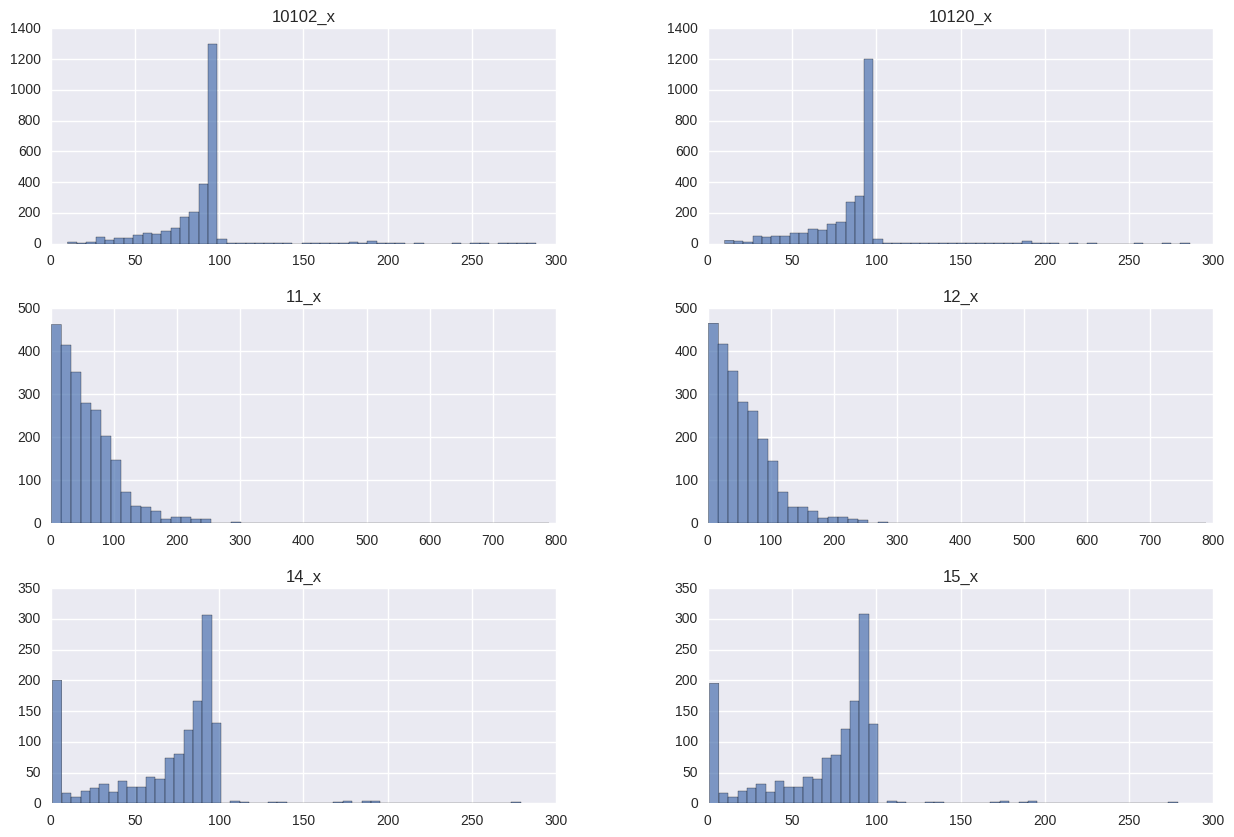

In [34]:
result[['id_ndaj1', '11_x', '12_x', '14_x', '15_x', '10102_x', '10120_x']].hist(figsize=(15, 10), bins=50, alpha=0.7)

# final mortality rate

In [35]:
float(result[result['dt_deces'].notnull()].shape[0]) / float(result.shape[0]) * 100.

21.91780821917808

# Create a parquet table using SparkSQL:
### id_nda (APHP stay) / j1 (date entrance ICU) / dt_deces (Dath date)

In [38]:
# start py-spark
import os
import sys

spark_home = os.environ.get('SPARK_HOME', "/opt/mapr/spark/spark-1.6.1")
os.environ['SPARK_HOME'] = spark_home
os.environ['PYSPARK_DRIVER_PYTHON'] ="jupyter"
os.environ['PYSPARK_DRIVER_PYTHON_OPTS']="notebook"
sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.8.2.1-src.zip'))
# execfile(os.path.join(spark_home, 'python/pyspark/shell.py'))

In [46]:
import py4j
import pyspark
import platform
import re
import shutil
from pyspark.sql import HiveContext
from pyspark.context import SparkContext, SparkConf
from pyspark.sql.types import *

In [41]:
conf = (SparkConf()
           .setMaster("local")
           .setAppName("PySparkShell")
           .set("spark.executor.memory", "8g")
           .set("spark.core.connection.ack.wait.timeout", "600")
           .set("spark.akka.frameSize", "512")
           .set("spark.cassandra.output.batch.size.bytes", "131072")
      )
if SparkContext._active_spark_context is None:
    sc = SparkContext(conf = conf)

In [42]:
from pyspark.sql import SQLContext
sql = SQLContext(sc)

In [85]:
# Transform result pandas DataFrame to Spark DataFrame
pd.options.mode.chained_assignment = None # to avoid pandas warnings

df_src_pd = result['id_ndaj1'].str.extract('(^[0-9]{7})([0-9]{4}-[0-9]{2}-[0-9]{2})', expand=False)
df_src_pd.columns = ['id_nda', 'j1']
df_src_pd['dt_deces'] = result.dt_deces.apply(str)
schema = StructType([
  StructField("id_nda", StringType(), True),
  StructField("j1", StringType(), True),
  StructField("dt_deces", StringType(), True)])
spark_df = sql.createDataFrame(df_src_pd, schema)

In [86]:
spark_df.limit(10).show()

+-------+----------+-------------------+
| id_nda|        j1|           dt_deces|
+-------+----------+-------------------+
|2744589|2014-05-08|2014-08-04 05:33:00|
|2744589|2014-06-24|2014-08-04 05:33:00|
|2754266|2014-05-05|                NaT|
|2758408|2014-05-12|2015-11-17 14:40:00|
|2760623|2014-05-01|                NaT|
|2764238|2014-05-06|2015-04-20 22:10:00|
|2766830|2014-05-23|                NaT|
|2771773|2014-05-11|                NaT|
|2773618|2014-05-06|2014-07-05 07:27:00|
|2778929|2014-07-14|2014-10-15 13:16:00|
+-------+----------+-------------------+



In [87]:
# save as parquet
spark_df.write.parquet("/user/mapr/eds/nda_j1_deces")

In [88]:
# sdf = spark_df.limit(10).toPandas()
# sdf

In [90]:
sc.stop()

In [92]:
#
# create table of useful sensors
#
ctas = "create table icu_sensor_util as \
select * from icu_sensor_24 where dt_cancel = '' \
and CONCAT(cast(id_nda as VARCHAR),cast(TO_DATE(dt_deb) as VARCHAR)) in \
(select distinct(CONCAT(cast(id_nda as VARCHAR),j1)) from nda_j1_deces)"

conn.execute(ctas)

In [93]:
q8 = "select count(1) from icu_sensor_util"
df_from_query(conn, q8)

,count
0,2817608
